# Chapter 9: Modeling Relationships #
&copy; 2019 Kenneth Winston

In the previous chapter we saw that markets in effect have moods &mdash; at times nervous, at times overconfident &mdash; that persist for a while but eventually revert to some long-term middle-of-the-road mood. We don't find it unusual when our high-strung friend has a meltdown because his socks don't match, but the same behavior in someone who is normally unflappable makes us sit up and take notice. It's the sudden change from a calm mood to panic, and the eventual relaxation back to calm, that produces fat-tailed distributions.

Fat tails would not be so concerning if they were idiosyncratic. A 10-standard-deviation event that affected only a small percentage of a portfolio would be attenuated if all the other assets in the portfolio were conducting business as usual. Fortunately that does sometimes happen, strengthening further the case for diversification.

But relationships between securities are themselves not stable, so what may be uncorrelated behavior in one period can become correlated in another period. In this chapter, we'll analyze relationships between securities and their time-varying properties.

## 9.1 Pearson Correlation ##

The standard measure of a relationship between two random variables $X$ and $Y$ is due to [Karl Pearson](https://www.encyclopediaofmath.org/index.php/Pearson,_Karl) and is accordingly called **`Pearson correlation`**:
$$\rho(X,Y)=\frac{\mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]}{\sigma_X\sigma_Y}\label{eq:pearson_correlation}\tag{9.1}$$
The standard deviations follow the usual definition:
$$\sigma_X^2=\mathbb{E}[(X-\mathbb{E}[X])^2]$$
and similarly for $\sigma_Y$.

Some obvious facts about Pearson correlation follow from the definition:
$$\rho(X,X)=1\tag{9.2a}$$
$$\rho(X,-X)=-1\tag{9.2b}$$
$$F_{X,Y}(x,y)=F_X(x)F_Y(y)\implies\rho(X,Y)=0\label{eq:correlation_independence}\tag{9.2c}$$
In words, \eqref{eq:correlation_independence} says that if $X$ and $Y$ are independent then they are uncorrelated.

However it is not necessarily true that if $X$ and $Y$ are uncorrelated, then they are independent. For example let $X$ be a standard normal random variable and let $Y=X^2$. Then $\mathbb{E}[X]=0$ so $\mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]=\mathbb{E}[XY]=\mathbb{E}[X^3]=0$ with the last equality coming about because the skewness of a normal distribution is zero. Thus $X$ and $Y$ are uncorrelated. But it's intuitively clear they aren't independent; formally we could for example look at $F_{X,Y}(1,1)$ and note that it's the same as $F_{X,Y}(\infty,1)$ since $Y\leq1$ means $X\leq1$. But it's not true that $F_X(1)F_Y(1)=F_X(\infty)F_Y(1)$, so they aren't independent.

Pearson correlations are very widely used and even non-statisticians have a general sense of what correlation means. News media frequently report social science studies whose main results are correlations between socially desirable or undesirable outcomes. For example, a correlation between early childhood education programs and later reduction in poverty rates might be reported. While the general public might not be able to write down \eqref{eq:pearson_correlation} if given a spot quiz, most people understand that the reported study implies that more early childhood education helps lower poverty.

But that may not be true. Virtually every statistics class repeats the warning **`correlation is not causation`**. A standard example is the supposed correlation between ice cream sales and the homicide rate. Ice cream does not cause homicides; warmer weather does. In warmer weather more people are outside interacting, sometimes murderously. By coincidence ice cream sales also go up in warmer weather. Clearly banning ice cream sales would not lower the homicide rate. Would increasing early childhood education cause poverty rates to go down? Correlation neither proves nor disproves that link; it's a necessary but not sufficient condition for the link to exist.

Correlation is a unitless quantity ranging from minus one to one. Even without the complications of causation, the existence of a nonzero correlation might not even be significant. The **`Fisher z-test`** allows us to estimate the statistical significance of an observed correlation. The test uses the **`Fisher z-transform`**:
$$z(\rho)=\frac{1}{2}ln\frac{1-\rho}{1+\rho}=arctanh(\rho)\label{eq:fisher_ztransfrom}\tag{9.3}$$

Figure 9.1 shows that the z-transform is near-linear when the correlation is small in absolute value. The straight line on the graph goes through the points where the z-transform equals $\pm1$.

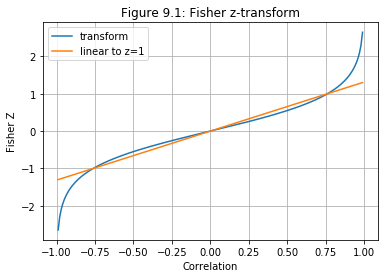

In [2]:
#Show Fisher z-transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def fisherz(rho):
    #Fisher z-transform
    return(.5*np.log((1+rho)/(1-rho)))

x=np.arange(-.99,.9999,.01)
plt.plot(x,fisherz(x),label="transform")

fzeq1=(np.exp(2)-1)/(np.exp(2)+1)  #argument where z-transform equals one
plt.plot(x,x/fzeq1,label="linear to z=1")
plt.title("Figure 9.1: Fisher z-transform")
plt.xlabel("Correlation")
plt.ylabel("Fisher Z")
plt.legend()
plt.grid()
plt.show();

Often we are interested in whether or not there is any correlation between two items; in other words, we want to see if we can reject the hypothesis that the correlation is zero. The standard error (standard deviation of the sampling distribution) of the Fisher z-transform is $\frac{1}{\sqrt{n-3}}$, where $n$ is the number of points in the sample from which we compute the sample correlation. This depends on the assumption that the two variables being correlated are bivariate normal.

So for example if there are 15 subjects in a sample, we need $arctanh(r)>\frac{1}{\sqrt{12}}$, or $r>tanh(\frac{1}{\sqrt{12}})=28.1\%$ (or $r<-28.1\%$) for the sample correlation $r$ to have less than a $16\%$ chance ($1-F^{-1}(1)$ where $F$ is the normal cdf) of being zero. Under the assumption of normality, an observed correlation outside the range $\pm56.2\%$ has less than a $2.5\%$ chance of occurring when the true correlation is zero.

The Fisher z-transform significance test is most useful when dealing with small samples &mdash; if n is very large, the standard error is extremely small.

## 9.2 Spearman Correlation ##

Pearson correlation is widely used, but it has some problems. If we have observations $(x_1,y_1),\dots,(x_n,y_n)$, then the finite version of the Pearson correlation in \eqref{eq:pearson_correlation} is
$$\rho(x,y)=\frac{\sum_{i=1}^n(x_i-\overline{x})(y_i-\overline{y})}{ns_Xs_Y}\label{eq:sample_pearson}\tag{9.4}$$
$\overline{x}$, $\overline{y}$, $s_x$ and $s_y$ are the sample means and standard deviations.

Large unusual observations &mdash; or just plain data errors &mdash; can affect the number disproportionately. For example, suppose we have the following observations of two quantitites at six different times:

| Time period | x observation | y observation |
:-:|-:|:-:|
| 1 | 1 | 1 |
| 2 | -0.1 | -0.1 |
| 3 | 1.5 | 1.5 |
| 4 | 1.7 | 1.7 |
| 5 | -1 | -1 |
| 6 | 5 | -2 |

The first five observations are the same and therefore have $100\%$ correlation. However the last large observation makes the overall correlation \eqref{eq:sample_pearson} negative ($-28\%$).

A variation on Pearson correlation that addresses this problem is due to [Charles Spearman](https://doi.org/10.1098%2Frsbm.1947.0006). **`Spearman correlation`** works from ranks rather than from the direct data.

Looking down the "x observation" column of the data table, we see that in the first time period, the $x$ observation is the number 1 which is the fourth biggest $x$: 5, 1.7, and 1.5 are bigger and -0.1 and -1 are smaller. For y observations, the 1 in the first time period is the third biggest. To compute a Spearman correlation, we would replace the first time period's observations with their ranks 4 and 3. Transforming the whole data table into a table of ranks gives

| Time period | x rank | y rank |
:-:|-:|:-:|
| 1 | 4 | 3 |
| 2 | 5 | 4 |
| 3 | 3 | 2 |
| 4 | 2 | 1 |
| 5 | 6 | 5 |
| 6 | 1 | 6 |

The Spearman correlation is just the Pearson correlation of the rank table. The Pearson/Spearman correlation between the two rank columns is $14.3\%$. The fact that the components of the last pair of observations are at complete opposite ends of the spectrum does bring down the correlation, but it doesn’t make it negative since the other five observations are more aligned.

More generally if we have a rank function $r_x$ so that $x(r_x(1))\geq x(r_x(2))\geq\dots\geq x(r_x(n))$, and similarly for $y$, then we look at the pairs $(r_x^{-1}(1),r_y^{-1}(1)),(r_x^{-1}(2),r_y^{-1}(2)),\dots,(r_x^{-1}(n),r_y^{-1}(n))$. Ties are treated by taking the average of the ranks that are tied, i.e. if observations 4 and 5 are the same then they are both given rank 4.5. The average of the numbers from 1 to n is $(n+1)/2$. So for Spearman correlation, \eqref{eq:sample_pearson} becomes
$$\rho_{Spearman}(x,y)=\frac{\sum_{i=1}^n \bigl(r_x^{-1}(i) r_y^{-1}(i)\bigr)-\frac{(n+1)^2}{4}}{n s_{r_x^{-1}}s_{r_y^{-1}}}\tag{9.5}$$
Here $s_{r_x^{-1}}$ is the standard deviation of the ranks of the $x$'s, which will be roughly $\sqrt{\frac{n^2-1}{2}}$, with variation depending on how many ranks are tied. Similarly for $s_{r_y^{-1}}$.

The code in the next cell performns the calculations for the Pearson/Spearman example.

In [3]:
import scipy.stats as spst
#Form ranks from Pearson example
x=[1,-.1,1.5,1.7,-1,5]
y=[1,-.1,1.5,1.7,-1,-2]

print("X data:",x)
xr=7-spst.rankdata(x)
print("X ranks:",xr)

print("Y data:",y)
yr=7-spst.rankdata(y)
print("Y ranks:",yr)

pearson,psig=spst.pearsonr(x,y)
#Compute Spearman by doing Pearson on ranks
spearman,ssig=spst.pearsonr(xr,yr)
#Direct call to Spearmsn
spear_scipy,sspsig=spst.spearmanr(x,y)

print("Pearson correlation:",pearson)
print("Spearman correlation from Pearson ranks:",spearman)
print("Spearman from scipy:",spear_scipy)

X data: [1, -0.1, 1.5, 1.7, -1, 5]
X ranks: [4. 5. 3. 2. 6. 1.]
Y data: [1, -0.1, 1.5, 1.7, -1, -2]
Y ranks: [3. 4. 2. 1. 5. 6.]
Pearson correlation: -0.2844419046262927
Spearman correlation from Pearson ranks: 0.14285714285714285
Spearman from scipy: 0.14285714285714288


## 9.3 Conditional Correlation ##

Often in financial applications we deal with a time series and are interested in estimating a future correlation. The correlations we've seen so far are static. They assume that there is a stationary underlying process being analyzed. But what if that's not true?

**`Conditional correlation`** is defined in a time series context. Assume we are observing stochastic processes $X_u$ and $Y_u$. We want to know what we expect the correlation to be at some later time $t$ based on what we knew at some earlier time $s$. That is, if $s<t$, we compute:
$$\rho_s(X_t,Y_t)=\frac{\mathbb{E}_s[(X_t-\mathbb{E}_s[X_t])(Y_t-\mathbb{E}_s[Y_t])]}{\sigma_s(X_t)\sigma_s(Y_t)}\tag{9.6}$$

Is this necessary? Maybe correlations are constant over time and we just need to compute a single unconditional correlation. It should be pretty clear that things will not be this easy, but let's check the data. 

The next cell imports daily log-returns of three regional stock indices &mdash North America, Europe, and Japan &mdash; going back to mid-1990. We then compute Pearson correlations between these regions.

In [5]:
import pandas as pd
    
ff_head='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'
ff_foot="_3_Factors_Daily_CSV.zip"
ff_names=["Europe","North_America","Japan"]

for name_index in range(len(ff_names)):
    print("Inputting ",ff_names[name_index])
    ffurl=ff_head+ff_names[name_index]+ff_foot
    #Skip the four header rows
    df_region = pd.read_csv(ffurl, skiprows=4)
    #Standardize name of Date column and market return column
    col0=df_region.columns[0]
    df_region.rename(columns={col0:'Date'},inplace=True)
    df_region.rename(columns={"Mkt-RF":ff_names[name_index]},inplace=True)
    #Merge into aggregate
    if name_index == 0:
        df_returns=df_region[df_region.columns[0:2]]
    else:
        df_returns = df_returns.merge(df_region[df_region.columns[0:2]], 
                            left_on='Date', right_on='Date')
        
#Convert to log-returns
df_logs=np.log(1+df_returns[df_returns.columns[1:]]/100).diff()
df_logs.insert(0,"Date",df_returns["Date"],True)
#Remove the first date
df_logs=df_logs.drop([0])
#Remove the partial year at the end
lastyear=np.unique(list(map(int,df_logs["Date"].values/10000)))[-1]
#Find the first index of the latest (partial) year in first_drop
for i in range(len(df_logs)):
    thisyear=int(df_logs.iloc[i]["Date"]/10000)
    if thisyear == lastyear:
        first_drop=i
        break
        
df_logs.drop(df_logs.index[first_drop:],inplace=True)

nobs=len(df_logs)
firstdate=df_logs.iloc[0]["Date"]
print(nobs," observations starting ",firstdate)

Inputting  Europe
Inputting  North_America
Inputting  Japan
7435  observations starting  19900703.0


With the data acquired, we can compute the $3\times3$ correlation matrix and the standard deviations of these securities:

In [13]:
#Get and show correlation matrix and
#standard deviations
corr_matrix=df_logs[df_logs.columns[1:]].corr()
cov_matrix=df_logs[df_logs.columns[1:]].cov()
std_devs=[]
for i in range(len(ff_names)):
    std_devs.append(np.sqrt(12*cov_matrix.iloc[i,i]))
    
print("Correlation matrix and standard deviations (9.10):")
print(corr_matrix)
print('Annualized standard deviations:\n',std_devs)
zsig=np.sqrt(1/(nobs-3))
rsig=(np.exp(2*zsig)-1)/(np.exp(2*zsig)+1)
print('Correlation significance:',rsig)

Correlation matrix and standard deviations (9.10):
                 Europe  North_America     Japan
Europe         1.000000       0.324787  0.160429
North_America  0.324787       1.000000 -0.139662
Japan          0.160429      -0.139662  1.000000
Annualized standard deviations:
 [0.05435430066802313, 0.053085919741958275, 0.06833692140836133]
Correlation significance: 0.011599190243130162


Looking at $tanh\bigl(\frac{1}{\sqrt{n-3}}\bigr)$ (see text after 9.3), we see that anything whose absolute correlation is over about 1.16% is significant. Thus all the correlations are significantly nonzero, as we would expect with so much data.

Relying on these correlations (and variances), we can compute the global minimum variance portfolio of the three regional indices:

In [14]:
#Compute minimum variance portfolio of three regions (4.17)
cov_matrix_inverse=pd.DataFrame(np.linalg.pinv(cov_matrix.values), \
            cov_matrix.columns,cov_matrix.index)
u=pd.Series([1]*len(cov_matrix_inverse),index=cov_matrix_inverse.index)
minvport=cov_matrix_inverse.dot(u)
minvar=1/minvport.dot(u)  #This is second part of formula (4.17)
minvport*=minvar    #This is first part of formula (4.17)
print('Minimum variance portfolio:')
print(minvport.to_string())

#Annualized standard deviation
annminstd=np.sqrt(minvar*12)
print('Minimum annualized std deviation:',annminstd)

Minimum variance portfolio:
Europe           0.221537
North_America    0.456639
Japan            0.321823
Minimum annualized std deviation: 0.0366369406825021


As we've seen before, portfolio construction allowed us to attain a standard deviation that was lower than the lowest individual standard deviation.

Recall from Chapter 4 that the variance of the global minimum variance portfolio is $\frac{1}{u^{T}C^{-1}u}$ where $C$ is the covariance matrix. Expanding the data in (9.10) into a covariance matrix and performing the calculation gives an annualized standard deviation of


In [22]:
df_logs.iloc[1000-samplesize:1000][df_logs.columns[1:]]


,Europe,North_America,Japan
245,0.012993,0.006538,-0.016667
246,0.003795,0.006893,0.030877
247,-0.019733,-0.014744,-0.012297
248,0.009814,0.012152,0.017253
249,0.011413,0.008350,-0.001286
250,-0.008999,-0.014156,-0.017074
251,-0.007157,0.000201,-0.000201
252,0.015061,-0.005637,-0.010429
253,-0.007000,0.009444,0.029880
254,0.003506,0.003892,-0.007138


Cholesky:
 [[ 1.          0.          0.        ]
 [ 0.39286997  0.91959404  0.        ]
 [ 0.14230492 -0.24310778  0.95950399]]


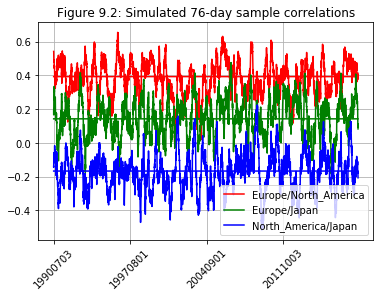

In [23]:
#Generate graph of either simulated or historical sample correlations
#from df_logs

def make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate):
#Generate a multivariate normal distribution using the data in df_logs
#compute sample correlations of size samplesize and graph them
#simulate: False, use historical data in df_logs
#          True, use simulated data in rtrial
    nobs=len(df_logs)
    nsecs=len(df_logs.columns)-1
    samplecorrs=[]
    corr_matrix=df_logs[df_logs.columns[1:]].corr()

    #Get sample correlations
    if simulate:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(np.corrcoef(rtrial[i-samplesize:i].transpose()))
    else:
        for i in range(samplesize,nobs+1):
            samplecorrs.append(df_logs.iloc[i-samplesize:i] \
                    [df_logs.columns[1:]].corr().values)
        
    #plot sample correlations
    sccol=['r','g','b']
    ncorrs=nsecs*(nsecs-1)/2
    z=0
    #Go through each pair
    for j in range(nsecs-1):
        for k in range(j+1,nsecs):
            #form time series of sample correlation
            #for this pair of securities
            scs=[samplecorrs[i][j,k] for i in range(nobs-samplesize+1)]
            plt.plot(range(nobs-samplesize+1),scs, \
                     label=corr_matrix.columns[j]+'/' \
                     +corr_matrix.columns[k], \
                     color=sccol[z])
            #Show target correlation in same color
            line=[corr_matrix.iloc[j,k]]*(nobs-samplesize+1)
            plt.plot(range(nobs-samplesize+1),line,color=sccol[z])
            z+=1

    plt.legend()
    stride=int((nobs-12+1)/(48))*12
    plt.xticks(range(0,nobs-samplesize+1,stride),df_logs.sort_values(by="Date")["Date"][0:nobs-samplesize+1:stride],rotation=45)
    plt.title(title_str+str(samplesize)+'-day sample correlations')
    plt.grid()
    plt.show();

#Generate a simulation    
#Show the Cholesky decomposition of the matrix
chol=np.linalg.cholesky(corr_matrix)
print('Cholesky:\n',chol)

#Generate random draws
nobs=len(df_logs)
nsecs=len(df_logs.columns)-1
strial=np.random.normal(0,1,size=[nobs,nsecs])
rtrial=np.matmul(chol,strial.T).T

samplesize=76
title_str="Figure 9.2: Simulated "
simulate=True
import matplotlib.pyplot as plt
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

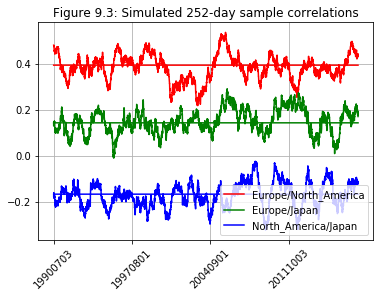

In [26]:
#Get sample 3-year simulated correlations
samplesize=252
title_str="Figure 9.3: Simulated "
simulate=True
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

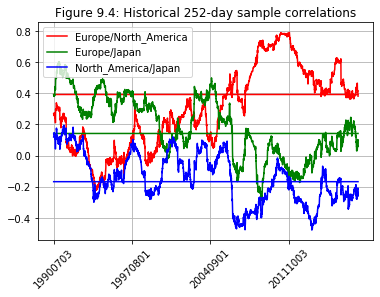

In [25]:
#Get sample 36-month historical correlations
samplesize=252
title_str="Figure 9.4: Historical "
simulate=False
make_corr_plot(df_logs, rtrial, samplesize, title_str, simulate)

In [36]:
#Read current holdings of SPY Exchange-Traded-Fund (ETF)
#This is very close to the actual S&P 500 index
#THere is a time mismatch - this is current while our options information is from
#yearend, so our implied correlations will be off a little
import pandas as pd
import time
import datetime
import numpy as np

start_time = time.perf_counter()
df_spy=pd.read_excel("https://us.spdrs.com/site-content/xls/SPY_All_Holdings.xls", \
                    skiprows=3)
df_spy.dropna(axis=0, how='any', inplace=True)   #Clean up junk at the end
#Extract tickers and weights
orig_spy_tickers=[]
weights=[]
for i in range(len(df_spy)):
    orig_spy_tickers.append(df_spy["Ticker"].iloc(0)[i].upper())
    weights.append(df_spy["Weight"].iloc(0)[i])
        
#force weights to add to 1
weights/=sum(weights)
end_time = time.perf_counter()
print("%d SPY tickers input, %7.3f seconds" % (len(weights),end_time-start_time))

yearend_string=str(datetime.datetime.now().year-1)
df_spy_options=pd.read_excel(r"SPY_UnderlyingOptionsEODCalcs_"+ \
                             yearend_string+"-12-31.xlsx")
end_time, start_time = time.perf_counter(), end_time
print("%d SPY options input, %7.3f seconds" % (len(df_spy_options), end_time-start_time))

#Get ATM implied vols for 3 months out; some have only 2 and 4 month options,
#in which case take average of 2 and 4 month ATM vols
spy_tickers=[]
implieds=[]
vis=[]   #vi's as in (9.16)
for i in range(len(orig_spy_tickers)):
    df_target=df_spy_options[df_spy_options.underlying_symbol == orig_spy_tickers[i]]
    if len(df_target)>0:
        spy_tickers.append(orig_spy_tickers[i])   #This one has options
        this_price = df_target.active_underlying_price_1545.unique()[0]
        quote_date = df_target.quote_date.unique()[0]
        #Find closest to the money
        min_to_money = min(abs(df_target.strike.unique()-this_price))
        df_ATM=df_target[abs(df_target.strike-this_price)==min_to_money]
        implieds.append(np.average(df_ATM.implied_volatility_1545))
        vis.append(implieds[-1]*weights[i])

end_time, start_time = time.perf_counter(), end_time
print("%d SPY tickers matched with options, %7.3f seconds" % (len(spy_tickers), end_time-start_time))

#Make histogram of implieds

n, bins, patches = plt.hist(implieds,bins=50)
plt.axvline(spx_ATM_60to90_implied, color='k', linestyle='dashed', linewidth=1)
plt.annotate('S&P 500 implied vol', xy=(spx_ATM_60to90_implied, .9*max(n)), 
            xytext=(np.average(implieds)*1.5, .9*max(n)), va='center', 
            color='k', arrowprops=dict(color='k',width=1,headwidth=4))
plt.annotate('Average implied vol', xy=(np.average(implieds), .7*max(n)), 
            xytext=(np.average(implieds)*1.5, .7*max(n)), va='center',
            color='r', arrowprops=dict(color='r',width=1,headwidth=4))

plt.axvline(np.average(implieds), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Annualized Implied Vol")
plt.ylabel("Count ("+str(len(implieds))+" total)")
plt.title("Figure 9.5: Histogram of ATM implieds vols of SPY components\n Expiring " \
          +str_exp+", Quoted "+stqd)
plt.grid()
plt.show()

#Show number greater than SPX implied
n_greater = sum(iv > spx_ATM_60to90_implied for iv in implieds)
print("SPX implied:",spx_ATM_60to90_implied)
print("Number greater:",n_greater)
print("Average implied:",np.average(implieds))

#Do calculation for formula 9.16
var_port=spx_ATM_60to90_implied**2
sum_vi2=sum([vi**2 for vi in vis])
sum_vi_2=sum(vis)**2
implied_corr=(var_port-sum_vi2)/(sum_vi_2-sum_vi2)
print("Implied correlation per formula (9.16):",implied_corr)

506 SPY tickers input,   0.519 seconds
47494 SPY options input,  19.256 seconds
470 SPY tickers matched with options,   2.814 seconds


NameError: name 'plt' is not defined

In [27]:
orig_spy_tickers=[]
weights=[]
for i in range(len(df_spy)):
    orig_spy_tickers.append(df_spy["Ticker"].iloc(0)[i].upper())
    weights.append(df_spy["Weight"].iloc(0)[i])
        
#force weights to add to 1
weights/=sum(weights)

In [31]:
sum(weights)

0.9999999999999987

In [9]:
import datetime

https://us.spdrs.com/site-content/xls/SPY_All_Holdings.xls?fund=SPY&docname=All+Holdings&onyx_code1=&onyx_code2=


#Note graph 9.5 was generated in Chapter 8 to avoid reloading large dataset
#Find the tickers of SPY components
start_time = time.perf_counter()
df_spy=pd.read_excel(r"SPY 20190302.xlsm")
orig_spy_tickers=[]
weights=[]
for i in range(len(df_spy)):
    if type(df_spy["Ticker"].iloc(0)[i]) == type(df_spy["Ticker"].iloc(0)[0]):
        orig_spy_tickers.append(df_spy["Ticker"].iloc(0)[i].upper())
        weights.append(df_spy["Percent"].iloc(0)[i])
        
#force weights to add to 1
weights/=sum(weights)
end_time = time.perf_counter()
print("SPY tickers input, %7.3f seconds" % (end_time-start_time))

yearend_string=str(datetime.datetime.now().year-1)
df_spy_options=pd.read_excel(r"SPY_UnderlyingOptionsEODCalcs_"+ \
                             yearend_string+"-12-31.xlsx")
end_time, start_time = time.perf_counter(), end_time
print("SPY options input, %7.3f seconds" % (end_time-start_time))

#Get ATM implied vols for 3 months out; some have only 2 and 4 month options,
#in which case take average of 2 and 4 month ATM vols
spy_tickers=[]
implieds=[]
vis=[]   #vi's as in (9.16)
for i in range(len(orig_spy_tickers)):
    df_target=df_spy_options[df_spy_options.underlying_symbol == orig_spy_tickers[i]]
    if len(df_target)>0:
        spy_tickers.append(orig_spy_tickers[i])   #This one has options
        this_price = df_target.active_underlying_price_1545.unique()[0]
        quote_date = df_target.quote_date.unique()[0]
        #Find closest to the money
        min_to_money = min(abs(df_target.strike.unique()-this_price))
        df_ATM=df_target[abs(df_target.strike-this_price)==min_to_money]
        implieds.append(np.average(df_ATM.implied_volatility_1545))
        vis.append(implieds[-1]*weights[i])

#Make histogram of implieds

n, bins, patches = plt.hist(implieds,bins=50)
plt.axvline(spx_ATM_60to90_implied, color='k', linestyle='dashed', linewidth=1)
plt.annotate('S&P 500 implied vol', xy=(spx_ATM_60to90_implied, .9*max(n)), 
            xytext=(np.average(implieds)*1.5, .9*max(n)), va='center', 
            color='k', arrowprops=dict(color='k',width=1,headwidth=4))
plt.annotate('Average implied vol', xy=(np.average(implieds), .7*max(n)), 
            xytext=(np.average(implieds)*1.5, .7*max(n)), va='center',
            color='r', arrowprops=dict(color='r',width=1,headwidth=4))

plt.axvline(np.average(implieds), color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Annualized Implied Vol")
plt.ylabel("Count ("+str(len(implieds))+" total)")
plt.title("Figure 9.5: Histogram of ATM implieds vols of SPY components\n Expiring " \
          +str_exp+", Quoted "+stqd)
plt.grid()
plt.show()

#Show number greater than SPX implied
n_greater = sum(iv > spx_ATM_60to90_implied for iv in implieds)
print("SPX implied:",spx_ATM_60to90_implied)
print("Number greater:",n_greater)
print("Average implied:",np.average(implieds))

#Do calculation for formula 9.16
var_port=spx_ATM_60to90_implied**2
sum_vi2=sum([vi**2 for vi in vis])
sum_vi_2=sum(vis)**2
implied_corr=(var_port-sum_vi2)/(sum_vi_2-sum_vi2)
print("Implied correlation per formula (9.16):",implied_corr)

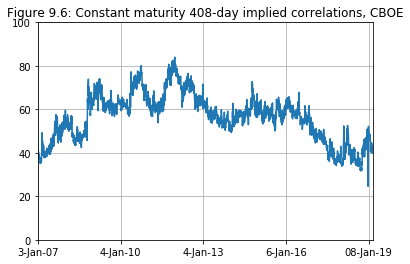

In [10]:
from datetime import date
from datetime import timedelta
#Read in CBOE implied correlation series and form
#constant-maturity series

url='http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/implied_correlation_hist.csv'

dfic=pd.read_csv(url,skiprows=1)

#Form option expiration dates; close enough
#to guess the 19th of January
expiries=[]
for i in range(3,len(dfic.columns)):
    expiries.append(date(int(dfic.columns[i][-4:]),1,19))
    
#In 2019 appears to be a misprint - last column should be 2021, not 2020
if expiries[-1]==expiries[-2]:
    expiries[-1]=date(expiries[-1].year+1,expiries[-1].month,expiries[-1].day)

#Interpolate current column and next column
offset=408   #New series are created around 408 days to expiration
             #offset gives max weight to new series at 408 days
currcol=3
interpcorr=[]
for i in range(len(dfic)):
    currdate=parser.parse(dfic.DATE[i]).date()
    #Is everything blank?
    if pd.DataFrame.all(pd.isna(dfic.iloc[i,3:])):
        ic=dfic.iloc[i,currcol]  #Leave value blank
    else:
        #Do we need to move to the next series?
        if pd.isna(dfic.iloc[i,currcol]):
            currcol+=1
        #Get bracketing correlations
        try:
            corr1=np.float64(dfic.iloc[i,currcol])
        except ValueError:
            corr1=0
        try:
            corr2=np.float64(dfic.iloc[i,currcol+1])
        except ValueError:
            corr2=0
        #Blank data?
        if corr2==0:
            ic=corr1
        elif corr1==0:
            ic=corr2
        else:
            #Figure weights based on how far from ideal (offset) days
            days1=expiries[currcol-3]-currdate
            days1=np.abs(days1.days-offset)
            days2=expiries[currcol-2]-currdate
            days2=np.abs(days2.days-offset)
            ic=days1*corr2+days2*corr1
            ic/=(days1+days2)
    interpcorr.append(ic)

#Appears to be a bad data point at 3-Mar-10. Also, interpolate where there are nans
badlist=[dfic.loc[dfic['DATE']=='3-Mar-10'].index[0]]+[x[0] for x in np.argwhere(np.isnan(interpcorr))]
#Interpolate around points on the badlist
for badindex in badlist:
    interpcorr[badindex]=(interpcorr[badindex-1]+interpcorr[badindex+1])/2

#interpcorr now has interpolated correlations; plot them
plt.plot(range(len(interpcorr)),interpcorr)
plt.grid()
plt.title('Figure 9.6: Constant maturity '+str(offset)+'-day implied correlations, CBOE')
icdates=dfic.DATE
nobs=len(icdates)
stride=int(nobs/48)*12
plt.xticks(range(0,nobs+stride,stride),icdates[0:nobs+stride:stride])
plt.xlim(0,nobs)
plt.ylim(0,100)
plt.show()

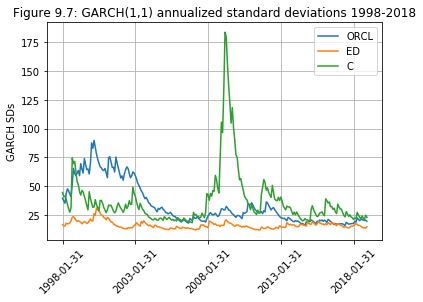

ORCL a=0.1188 b=0.8626 c=0.00011996 AnnEquilibStd=0.2786
ED a=0.1138 b=0.8001 c=0.00018801 AnnEquilibStd=0.1619
C a=0.2359 b=0.7193 c=0.00065883 AnnEquilibStd=0.4198


In [12]:
import scipy.stats as spst
from scipy.optimize import minimize_scalar

#CHEAT! - get overall mean and standard deviation vectors
#In practice, would need to do everything out of sample - start with a learning sample, e.g.
overallmean=np.mean(df_logs)
overallstd=np.std(df_logs)

#Get GARCH params for each ticker
gparams=[]
initparams=[.12,.85,.6]
stgs=[] #Save the running garch sigma's
for it,ticker in enumerate(tickerlist):
    #Note ORDER MATTERS: make sure values are in date order
    gparams.append(qf.Garch11Fit(initparams,df_logs.sort_values(by="Date")[ticker]))
    a,b,c=gparams[it]
    
    #Create time series of sigmas
    t=len(df_logs[ticker])
    minimal=10**(-20)
    stdgarch=np.zeros(t)
    stdgarch[0]=overallstd[ticker]
    #Compute GARCH(1,1) stddev's from data given parameters
    for i in range(1,t):
        #Note offset - i-1 observation of data
        #is used for i estimate of std deviation
        previous=stdgarch[i-1]**2
        var=c+b*previous+\
            a*(df_logs.sort_values(by="Date")[ticker][i-1]-overallmean[ticker])**2
        stdgarch[i]=np.sqrt(var)

    #Save for later de-GARCHing
    stgs.append(stdgarch)
    
#Create plot
for it,ticker in enumerate(tickerlist):
    #Annualize
    stdgarch=100*np.sqrt(12)*stgs[it]
    plt.plot(range(len(stdgarch)),stdgarch,label=ticker)

plt.grid()
plt.title('Figure 9.7: GARCH(1,1) annualized standard deviations '+ \
          str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year))
plt.ylabel('GARCH SDs')
plt.legend()
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.show()

for it,tick in enumerate(tickerlist):
    print(tick,'a=%1.4f' % gparams[it][0], \
               'b=%1.4f' % gparams[it][1], \
               'c=%1.8f' % gparams[it][2], \
               'AnnEquilibStd=%1.4f' % \
               np.sqrt(12*gparams[it][2]/(1-gparams[it][0]-gparams[it][1])))

In [14]:
#Display before and after statistics
for it,ticker in enumerate(tickerlist):
    print(ticker)
    print('    Raw monthly Std Dev:',overallstd[ticker])
    print('    Raw annualized Std Dev:',np.sqrt(12)*overallstd[ticker])
    print('    Raw excess kurtosis:',spst.kurtosis(df_logs[ticker]))

#Demeaned, DeGARCHed series go in dfeps
dfeps=df_logs.sort_values(by="Date").copy()
for it,ticker in enumerate(tickerlist):
    dfeps[ticker]-=overallmean[it]
    for i in range(len(dfeps)):
        dfeps[ticker].iloc[i]/=stgs[it][i]
    print(ticker)
    print('    DeGARCHed Mean:',np.mean(dfeps[ticker]))
    print('    DeGARCHed Std Dev:',np.std(dfeps[ticker]))
    print('    DeGARCHed Excess Kurtosis:',spst.kurtosis(dfeps[ticker]))

ORCL
    Raw monthly Std Dev: 0.1138358827513424
    Raw annualized Std Dev: 0.39433906529955726
    Raw excess kurtosis: 3.689365272570827
ED
    Raw monthly Std Dev: 0.04739154755205673
    Raw annualized Std Dev: 0.16416913641895742
    Raw excess kurtosis: 0.6762335672014315
C
    Raw monthly Std Dev: 0.1277675499905242
    Raw annualized Std Dev: 0.44259977628436864
    Raw excess kurtosis: 11.593201066693771


C:\Users\kenwi\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ORCL
    DeGARCHed Mean: -0.026090741618431307
    DeGARCHed Std Dev: 1.010740795498199
    DeGARCHed Excess Kurtosis: -0.07645334962631889
ED
    DeGARCHed Mean: 0.0010706622375457238
    DeGARCHed Std Dev: 1.0039611337283445
    DeGARCHed Excess Kurtosis: 0.04862823222459234
C
    DeGARCHed Mean: 0.029402682821840425
    DeGARCHed Std Dev: 1.0039947597882661
    DeGARCHed Excess Kurtosis: 2.0571586363219287


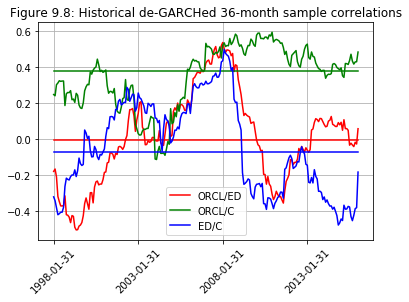

In [15]:
#Get sample 36-month de-GARCHED correlations
samplesize=36
title_str="Figure 9.8: Historical de-GARCHed "
simulate=False
make_corr_plot(dfeps, rtrial, samplesize, title_str, simulate)

Optimal lambda: 0.0191710841396228
Optimal objective function: 733.290602158207
Half-life (months): 35.80817593350826


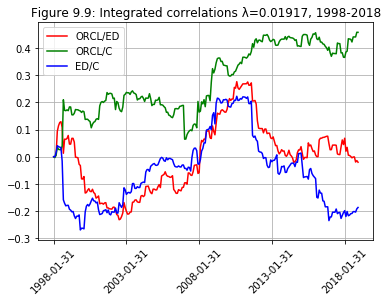

In [16]:
#Compute integrated correlations

InData=np.array(dfeps[tickerlist])

def IntegratedCorrObj(s):
    #Compute time series of quasi-correlation
    #matrices from InData using integrated parameter
    #xlam=exp(s)/(1+exp(s)); note this format removes
    #the need to enforce bounds of xlam being between
    #0 and 1. This is applied to formula 9.34.
    #Standardize Q's and apply formula 9.39.
    #Returns scalar 9.39
    xlam=np.exp(s)
    xlam/=1+xlam
    obj9p39=0.
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=xlam*shockmat+(1-xlam)*previousq
    return(obj9p39[0,0])
#Done with IntegratedCorrObj

result=minimize_scalar(IntegratedCorrObj)

xlamopt=np.exp(result.x)
xlamopt/=1+xlamopt
print('Optimal lambda:',xlamopt)
print('Optimal objective function:', \
      result.fun)
if xlamopt>=1 or xlamopt==0:
    halflife=0
else:
    halflife=-np.log(2)/np.log(1-xlamopt)
print('Half-life (months):',halflife)

#Plot integrated correlations
previousq=np.identity(len(InData[0]))
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=xlamopt*shockmat+(1-xlamopt)*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(InData)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt], \
            color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.9: Integrated correlations λ=%1.5f' % xlamopt
xtitle+=', '+str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year)
plt.title(xtitle)
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.legend()
plt.show()

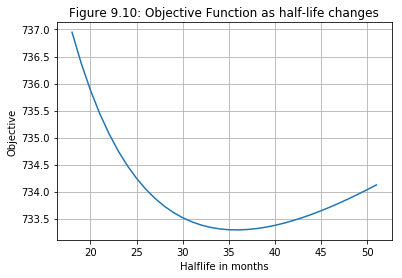

In [17]:
#Map of objective with respect to half-life
halflife=int(halflife)
delta_halflife=int(halflife/2)
y=[]
for h in range(halflife-delta_halflife,halflife+delta_halflife):
    xlam=1-(.5)**(1/h)
    s=np.log(xlam/(1-xlam))    
    y.append(IntegratedCorrObj(s))
    
plt.plot(range(halflife-delta_halflife,halflife+delta_halflife),y)
plt.title("Figure 9.10: Objective Function as half-life changes")
plt.xlabel("Halflife in months")
plt.ylabel("Objective")
plt.grid()
plt.show();

C:\Users\kenwi\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimal alpha, beta: 0.029196165404162394 0.892109118963283
Optimal objective function: 721.9125799670844
Half-life (months): 23.392749746760817


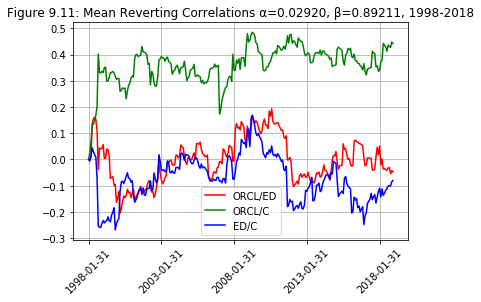

In [18]:
def MeanRevCorrObj(params):
    #Compute time series of quasi-correlation
    #matrices from InData using mean reverting
    #formula 9.35. Standardize them and apply
    #formula 9.39. Returns scalar 9.39
    
    #Extract parameters
    alpha,beta=params
    #Enforce bounds
    if alpha<0 or beta<0:
        return(10**20)
    elif (alpha+beta)>.999:
        return(10**20)
    obj9p39=0
    #Initial omega is obtained through correlation targeting
    Rlong=np.corrcoef(InData.T)
    previousq=np.identity(len(InData[0]))
    #Form new shock matrix
    for i in range(len(InData)):
        #standardize previous q matrix
        #and compute contribution to objective
        #function
        stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
        previousr=np.matmul(stdmtrx,np.matmul(previousq,stdmtrx))
        #objective function
        obj9p39+=np.log(np.linalg.det(previousr))
        shockvec=np.array(InData[i])
        vec1=np.matmul(shockvec,np.linalg.inv(previousr))
        #This makes obj9p39 into a 1,1 matrix
        obj9p39+=np.matmul(vec1,shockvec)
              
        #Update q matrix
        shockvec=np.mat(shockvec)
        shockmat=np.matmul(shockvec.T,shockvec)
        previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq
    return(obj9p39[0,0])
#Done with MeanRevCorrObj

import scipy.optimize as scpo
#alpha and beta positive
corr_bounds = scpo.Bounds([0,0],[np.inf,np.inf])
#Sum of alpha and beta is less than 1
corr_linear_constraint = \
    scpo.LinearConstraint([[1, 1]],[0],[.999])

initparams=[.02,.93]

results = scpo.minimize(MeanRevCorrObj, \
        initparams, \
        method='trust-constr', \
        jac='2-point', \
        hess=scpo.SR1(), \
        bounds=corr_bounds, \
        constraints=corr_linear_constraint)

alpha,beta=results.x
print('Optimal alpha, beta:',alpha,beta)
print('Optimal objective function:',results.fun)
halflife=-np.log(2)/np.log(1-alpha)
print('Half-life (months):',halflife)

#Plot mean reverting correlations
previousq=np.identity(len(InData[0]))
Rlong=np.corrcoef(InData.T)
rmatrices=[]
for i in range(len(InData)):
    stdmtrx=np.diag([1/np.sqrt(previousq[s,s]) for s in range(len(previousq))])
    rmatrices.append(np.matmul(stdmtrx,np.matmul(previousq,stdmtrx)))
    shockvec=np.mat(np.array(InData[i]))
    #Update q matrix
    shockmat=np.matmul(shockvec.T,shockvec)
    previousq=(1-alpha-beta)*Rlong+alpha*shockmat+beta*previousq

iccol=['r','g','b']
z=0
for it in range(len(tickerlist)-1):
    for jt in range(it+1,len(tickerlist)):
        y=[rmatrices[i][it,jt] for i in range(len(InData))]
        plt.plot(range(len(dfeps)),y, \
            label=tickerlist[it]+'/'+tickerlist[jt], \
            color=iccol[z])
        z+=1
plt.grid()
xtitle='Figure 9.11: Mean Reverting Correlations α=%1.5f' % alpha
xtitle+=', β=%1.5f' % beta
xtitle+=', '+str(min(df_logs["Date"]).year)+'-'+str(max(df_logs["Date"]).year)
plt.title(xtitle)
stride=60
plt.xticks(range(0,len(df_logs),stride),df_logs.sort_values(by="Date")["Date"][0:len(df_logs)-1:stride],rotation=45)
plt.legend()
plt.show();

In [331]:
#MacGyver method - pairwise integrated
minimal=10**(-20)
xlams=[]
for it in range(len(tickerlist)-1):
    tick1=tickerlist[it]
    for jt in range(it+1,len(tickerlist)):
        tick2=tickerlist[jt]
        InData=np.array(dfeps[[tick1,tick2]])
        result=minimize_scalar(IntegratedCorrObj)
        xlamopt=np.exp(result.x)/(1+np.exp(result.x))
        print(tick1,tick2)
        print('    Optimal lambda:',xlamopt)
        print('    Optimal objective function:', \
              result.fun)
        if np.absolute(xlamopt)<minimal or xlamopt>=1:
            halflife=0
        else:
            halflife=-np.log(2)/np.log(1-xlamopt)
        print('    Half-life (months):',halflife)
        xlams.append(xlamopt)

print('\nMedian MacGyver lambda:',np.median(xlams))

ORCL ED
    Optimal lambda: 1.333223459588212e-32
    Optimal objective function: 511.6146302829898
    Half-life (months): 0
ORCL C
    Optimal lambda: 0.021010821008751335
    Optimal objective function: 476.64410498936513
    Half-life (months): 32.64220915900315
ED C
    Optimal lambda: 0.03712176487443477
    Optimal objective function: 509.3166556221824
    Half-life (months): 18.323499665941718

Median MacGyver lambda: 0.021010821008751335


In [ ]:
#Acquire log-return data
#Intrinio only returns 100 data points per request
#(you can ask for more once or twice, but it will quickly tell you that you are asking for too much)
#So you have to iterate requests if you want more than 100 data points; that's taken care in this code segment

import intrinio_sdk
from intrinio_sdk.rest import ApiException
from dateutil import parser
import numpy as np
import pandas as pd
import qrbook_funcs as qf

#Give access information
#intrinio_sdk.ApiClient().configuration.api_key['api_key'] = #Insert your intrinio API key here
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = "OmYyZjU1MjA0NzgzYTdjNTI5Nzg5ZGIyNjI3MTIxNGZi"
security_api = intrinio_sdk.SecurityApi()

#List of period-end dates
date_list=[]; need_dates = True

tickerlist=['ORCL','ED','C']
start_date='1997-12-31'
sd_dateform=parser.parse(start_date).date()   #format compatible with Intrinio
end_date=qf.LastYearEnd()[:4]+'-12-31' #Intrinio uses 12-31 even if it's not a business day
frequency = 'monthly'

for identifier in tickerlist:
    print('Inputting ',identifier)
    next_page = None
    date_offset = 0
    try:
        while True:  #loop through pages - only get 100 data points at a time
            if next_page is None:    #Intrinio can't take a next_page=None argument
                #First call to get_security_stock_prices
                api_response = security_api.get_security_stock_prices(identifier, \
                    start_date=start_date, end_date=end_date, \
                    frequency=frequency)
                lr_list=[]
                if need_dates:    #First security?
                    date_list=[]
                new_obs=api_response.stock_prices[0].adj_close    #prime the new_obs pump
            else:
                #There was a previous call to get_security_stock_prices
                api_response = security_api.get_security_stock_prices(identifier, \
                    start_date=start_date, end_date=end_date, \
                    frequency=frequency, next_page = next_page)
                #compute log-return that spans two calls of get_security_stock_prices
                old_obs=api_response.stock_prices[0].adj_close
                lr_list.append(np.log(new_obs/old_obs))
                new_obs=old_obs
            #transfer to list
            num_obs=len(api_response.stock_prices)
            next_next_page = api_response.next_page    #used to see if we are on the last iteration
            for i in range(num_obs):
                if (next_next_page is None) and (i==num_obs-1):   #last iteration, don't record last date
                    break    #for i
                this_date=api_response.stock_prices[i].date
                if need_dates:
                    date_list.append(this_date)
                else:
                    if this_date != date_list[i+date_offset]:
                        print('Date disagreement',identifier,date_list[i+date_offset],this_date)
                        exit()
                if i < num_obs-1:
                    old_obs=api_response.stock_prices[i+1].adj_close
                    lr_list.append(np.log(new_obs/old_obs))
                    new_obs=old_obs

            date_offset += num_obs
            next_page = next_next_page
            if next_page is None:
                break     #while
                
    except ApiException as e:
        print("Exception when calling SecurityApi->get_security_historical_data: %s\n" % e)
    #end try - this security now acquired
    #transfer to dataframe
    
    if need_dates:
        need_dates = False
        #reverse order so oldest is first
        df_logs = pd.DataFrame({'Date':date_list[::-1]})

    df_logs[identifier] = lr_list[::-1]  #reverse order to agree with dates
    #end for loop
    
#df_logs is a dataframe that has month-end dates (df_logs['Date']) and
#log-returns of the tickers in tickerlist, e.g. df_logs['AAPL']

print("Data acquired.",len(tickerlist),' tickers, ',len(df_logs),' observations.')

In [244]:
import pandas as pd
    
ff_head='http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'
ff_foot="_3_Factors_Daily_CSV.zip"
ff_names=["Europe","North_America","Japan"]

for name_index in range(len(ff_names)):
    ffurl=ff_head+ff_names[name_index]+ff_foot
    #Skip the four header rows
    df_region = pd.read_csv(ffurl, skiprows=4)
    #Standardize name of Date column and market return column
    col0=df_region.columns[0]
    df_region.rename(columns={col0:'Date'},inplace=True)
    df_region.rename(columns={"Mkt-RF":ff_names[name_index]},inplace=True)
    #Merge into aggregate
    if name_index == 0:
        df_returns=df_region[df_region.columns[0:2]]
    else:
        df_returns = df_returns.merge(df_region[df_region.columns[0:2]], 
                            left_on='Date', right_on='Date')
        
#Convert to log-returns
df_logs=np.log(1+df_returns[df_returns.columns[1:]]/100).diff()
df_logs.insert(0,"Date",df_returns["Date"],True)
#Remove the first date
df_logs=df_logs.drop([0])
#Remove the partial year at the end
lastyear=np.unique(list(map(int,df_logs["Date"].values/10000)))[-1]
#Find the first index of the latest (partial) year in first_drop
for i in range(len(df_logs)):
    thisyear=int(df_logs.iloc[i]["Date"]/10000)
    if thisyear == lastyear:
        first_drop=i
        break
        
df_logs.drop(df_logs.index[first_drop:],inplace=True)

In [245]:
df_logs

,Date,Europe,North_America,Japan
1,19900703,-0.006557,-0.001596,-0.007764
2,19900704,-0.000897,-0.001499,0.013696
3,19900705,-0.008818,-0.009950,-0.020816
4,19900706,0.007220,0.015635,0.006221
5,19900709,0.004088,-0.003586,-0.000100
6,19900710,-0.004788,-0.008217,0.009458
7,19900711,-0.003506,0.015972,-0.007060
8,19900712,0.009487,0.000198,-0.000599
9,19900713,-0.001293,-0.005261,0.011911
10,19900716,-0.001693,-0.000797,-0.005739


In [243]:
df_logs

,Date,Europe,North_America,Japan
0,19900702,NaN,NaN,NaN
1,19900703,-0.006557,-0.001596,-0.007764
2,19900704,-0.000897,-0.001499,0.013696
3,19900705,-0.008818,-0.009950,-0.020816
4,19900706,0.007220,0.015635,0.006221
5,19900709,0.004088,-0.003586,-0.000100
6,19900710,-0.004788,-0.008217,0.009458
7,19900711,-0.003506,0.015972,-0.007060
8,19900712,0.009487,0.000198,-0.000599
9,19900713,-0.001293,-0.005261,0.011911


In [247]:
#Get and show correlation matrix and
#standard deviations
nobs=len(df_logs)
corr_matrix=df_logs[df_logs.columns[1:]].corr()
cov_matrix=df_logs[df_logs.columns[1:]].cov()
std_devs=[]
for i in range(len(tickerlist)):
    std_devs.append(np.sqrt(12*cov_matrix.iloc[i,i]))
    
print("Correlation Matrix and standard deviations (9.10):")
print(corr_matrix)
print('Annualized standard deviations:\n',std_devs)
zsig=np.sqrt(1/(nobs-3))
rsig=(np.exp(2*zsig)-1)/(np.exp(2*zsig)+1)
print('Correlation significance:',rsig)


Correlation Matrix and standard deviations (9.10):
                 Europe  North_America     Japan
Europe         1.000000       0.392870  0.142305
North_America  0.392870       1.000000 -0.167653
Japan          0.142305      -0.167653  1.000000
Annualized standard deviations:
 [0.05435430066802313, 0.053085919741958275, 0.06833692140836133]
Correlation significance: 0.011599190243130162


In [38]:
import numpy as np
#Ledoit-Wolf matrix
r=np.corrcoef(c)
ndim=int(r.size**.5)
avcorr=(np.sum(r)-ndim)/(r.size-ndim)
ccorr=np.full((ndim,ndim),avcorr)
np.fill_diagonal(ccorr,1.)
#ccorr now has 1's on the diagonal and
#average correlation off the diagonal
#reflate it to a covariance matrix
smtrx=np.sqrt(np.diagflat(np.diag(c)))
ccorrcov=np.matmul(np.matmul(smtrx,ccorr),smtrx)
print('Const correlation covariance mtrx:\n',ccorrcov*10000)
#shrinkage parameter
shrinkage=1./3.
covshrunk=shrinkage*ccorrcov+(1-shrinkage)*c
print('Shrunk covariance matrix:\n',covshrunk*10000)

#invert the shrunk c matrix
csi=np.linalg.inv(covshrunk)/10000
print('Inverse of shrunk cov:\n',csi)
ucsiu=np.sum(csi)
vec2shrunk=np.matmul(csi,u)/ucsiu
print('Shrunk minvar portfolio:',vec2shrunk)
#Get the most recent year covariance matrix
lastday=LastYearEnd()
year=int(lastday[:4])-1
import datetime as dt
for day in [31,30,29,28]:
    l=dt.date(year,12,day)
    if l.weekday()<5:
        firstday=str(year)+'-12-'+str(day)
        break
seriesnames=['DEXSZUS','DEXUSEU','DEXUSUK','DEXJPUS']
cdates,ratematrix=GetFREDMatrix(seriesnames,
                        startdate=firstday,enddate=lastday)
oldstate=np.seterr(all='ignore')
#Convert levels to log-returns
#First take logs of the currency levels
#Swissie and yen are in currency/dollar, but
#the other two are dollar/currency. Reverse sign
#of the Euro and Pound.
multipliers=[-1,1,1,-1]
lgrates=[]
for i in range(len(ratematrix)):
    lgrates.append(list(np.log(ratematrix[i])))
    lgrates[i]=list(np.multiply(lgrates[i],multipliers))

#take differences of the logs.
#get rid of any where Yen doesn't have data
difflgs=[]
lgdates=[]
idxold=0   #Keeps track of the last good time period
for i in range(1,len(ratematrix)):    
    x=list(np.subtract(lgrates[i],lgrates[idxold]))
    if pd.notna(x[3]):
        difflgs.append(x)
        lgdates.append(cdates[i])
        idxold=i
np.seterr(**oldstate)
#compute covariance matrix
idx=0
#Euro doesn't start until later
#idx=lgdates.index('1999-01-04')
#Not using Euro - delete column 1
d=np.delete(np.array(difflgs[idx:]),1,1)
clst=np.cov(d.T)
print(year+1,' Covariance matrix:\n',clst*10000)
#compute standard devs
oldmin=np.matmul(np.matmul(vec2,clst),vec2.T)
newmin=np.matmul(np.matmul(vec2shrunk,clst),vec2shrunk.T)
print('Old std dev:',np.sqrt(oldmin))
print('Shrunk std dev:',np.sqrt(newmin))


NameError: name 'c' is not defined